In [94]:
import pandas as pd
import numpy as np
import torch.nn as nn
import torch
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from scipy.stats import norm,t

In [95]:
dic = [ "amd","aapl", "ba", "biib", "jpm", "meta", "ngg", "pdd", "ryaay", "tsla",'nasdaq']
company_lst=[ "amd","aapl", "ba", "biib", "jpm", "meta", "ngg", "pdd", "ryaay", "tsla"]
in_path="stocks/"
for i, ticker in enumerate(dic):
    stock = in_path + f"{ticker}.csv"
    stock_df = pd.read_csv(stock, index_col="Date")[["Adj Close"]]
    if i == 0:
        df_close = stock_df
        df_close.columns = [ticker]
    else:
        df_close[ticker] = stock_df
df_close = df_close.dropna()
df_close.head()

amd        aapl          ba        biib         jpm  \
Date                                                                     
2022-01-03  150.240005  181.259933  207.860001  244.139999  156.752411   
2022-01-04  144.419998  178.959442  213.630005  241.729996  162.694855   
2022-01-05  136.149994  174.199158  213.070007  239.270004  159.720444   
2022-01-06  136.229996  171.291183  211.339996  237.300003  161.417328   
2022-01-07  132.000000  171.460495  215.500000  232.600006  163.016678   

                  meta        ngg        pdd       ryaay        tsla  \
Date                                                                   
2022-01-03  338.540009  70.250885  56.099998  106.440002  399.926666   
2022-01-04  336.529999  70.386894  49.820000  109.050003  383.196655   
2022-01-05  324.170013  69.706833  48.529999  110.250000  362.706665   
2022-01-06  332.459991  69.007339  52.130001  111.599998  354.899994   
2022-01-07  331.790009  69.570824  55.900002  115.989998  342.320007   

                  nasdaq  
Date                      
2022-01-03  15832.799805  
2022-01-04  15622.719727  
2022-01-05  15100.169922  
2022-01-06  15080.860352  
2022-01-07  14935.900391

In [96]:
df_return=df_close.pct_change().dropna()
df_return.head()

amd      aapl        ba      biib       jpm      meta  \
Date                                                                     
2022-01-04 -0.038738 -0.012692  0.027759 -0.009871  0.037910 -0.005937   
2022-01-05 -0.057264 -0.026600 -0.002621 -0.010177 -0.018282 -0.036728   
2022-01-06  0.000588 -0.016693 -0.008119 -0.008233  0.010624  0.025573   
2022-01-07 -0.031050  0.000988  0.019684 -0.019806  0.009908 -0.002015   
2022-01-10  0.000000  0.000116 -0.028724  0.011651  0.000957 -0.011212   

                 ngg       pdd     ryaay      tsla    nasdaq  
Date                                                          
2022-01-04  0.001936 -0.111943  0.024521 -0.041833 -0.013269  
2022-01-05 -0.009662 -0.025893  0.011004 -0.053471 -0.033448  
2022-01-06 -0.010035  0.074181  0.012245 -0.021523 -0.001279  
2022-01-07  0.008166  0.072319  0.039337 -0.035447 -0.009612  
2022-01-10 -0.000978  0.019499 -0.000172  0.030342  0.000464

## Portfolio VAR/ES based on past data (normal and t distribution)

In [274]:
date='2022-09-30'
stock_return=df_return.copy().loc[:date,:'tsla']
w = np.array([0.1]*10)
WeightedR = stock_return.mul(w, axis=1)

Return = WeightedR.sum(axis=1)

## Fit Normal
mu_norm, sig_norm = norm.fit(Return) # extract the mean and sigma of the closest normal distribution fit
print("Normal mean is {0:.8f}, sigma is {1:.8f}".format(mu_norm, sig_norm))
dx = 0.0001 # resolution of the distribution
x = np.arange(-1, 1, dx)
pdf_n = norm.pdf(x, mu_norm, sig_norm)

Normal mean is -0.00153553, sigma is 0.02330004


In [275]:
stock_return.head()

amd      aapl        ba      biib       jpm      meta  \
Date                                                                     
2022-01-04 -0.038738 -0.012692  0.027759 -0.009871  0.037910 -0.005937   
2022-01-05 -0.057264 -0.026600 -0.002621 -0.010177 -0.018282 -0.036728   
2022-01-06  0.000588 -0.016693 -0.008119 -0.008233  0.010624  0.025573   
2022-01-07 -0.031050  0.000988  0.019684 -0.019806  0.009908 -0.002015   
2022-01-10  0.000000  0.000116 -0.028724  0.011651  0.000957 -0.011212   

                 ngg       pdd     ryaay      tsla  
Date                                                
2022-01-04  0.001936 -0.111943  0.024521 -0.041833  
2022-01-05 -0.009662 -0.025893  0.011004 -0.053471  
2022-01-06 -0.010035  0.074181  0.012245 -0.021523  
2022-01-07  0.008166  0.072319  0.039337 -0.035447  
2022-01-10 -0.000978  0.019499 -0.000172  0.030342

In [276]:
## Fit T
nu, mu_t, sig_t = t.fit(Return)
nu = np.round(nu)
print("Student T mean is {0:.8f}, sigma is {1:.8f}, nu is {2}".format(mu_t, sig_t, nu))
pdf_t = t.pdf(x, nu, mu_t, sig_t)

Student T mean is -0.00171377, sigma is 0.02168328, nu is 15.0


In [277]:
h = 1
alpha = 0.01
xanu = t.ppf(alpha, nu)

CVaR_n = alpha**-1 * norm.pdf(norm.ppf(alpha))*sig_norm - mu_norm
VaR_n = norm.ppf(1-alpha)*sig_norm - mu_norm

VaR_t = np.sqrt((nu-2)/nu) * t.ppf(1-alpha, nu)*sig_norm  - h*mu_norm
CVaR_t = -1/alpha * (1-nu)**(-1) * (nu-2+xanu**2) * t.pdf(xanu, nu)*sig_norm  - h*mu_norm

print("The 99% VaR (Normal) is {0:.2f}%".format(VaR_n*100))
print("The 99% CVaR (Normal) is {0:.2f}%".format(CVaR_n*100))
print("The 99% VaR (Student-t) is {0:.2f}%".format(VaR_t*100))
print("The 99% CVaR (Student-t) is {0:.2f}%".format(CVaR_t*100))

The 99% VaR (Normal) is 5.57%
The 99% CVaR (Normal) is 6.36%
The 99% VaR (Student-t) is 5.80%
The 99% CVaR (Student-t) is 6.71%


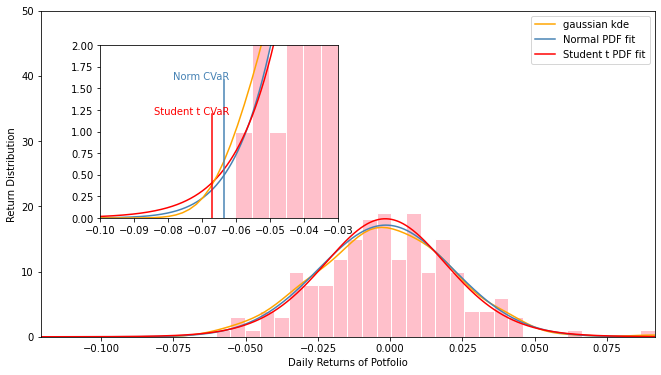

In [279]:
from scipy.stats import gaussian_kde
plt.figure(num=1, figsize=(11, 6))
# main figure
plt.hist(Return, bins=30, color='pink', edgecolor='white')
plt.axis("tight")
kde = gaussian_kde(Return)
xx = np.linspace(-0.1, 0.1, 100)
plt.plot(xx, kde(xx),'orange',label='gaussian kde')
plt.axis("tight")
plt.plot(x, pdf_n, 'steelblue', label="Normal PDF fit")
plt.axis("tight")
plt.plot(x, pdf_t, 'red', label="Student t PDF fit")
plt.xlim([min(Return)*2, max(Return)])
plt.ylim([0,50])
plt.legend(loc="best")
plt.xlabel("Daily Returns of Potfolio")
plt.ylabel("Return Distribution")
# inset
a = plt.axes([.2, .4, .3, .4])
plt.hist(Return, bins=30, color='pink', edgecolor='white')
plt.plot(x, pdf_n, 'steelblue')
plt.plot(x, pdf_t, 'red')
plt.plot(xx, kde(xx),'orange')
# Student VaR line
plt.plot([-CVaR_t, -CVaR_t], [0, 1.2], c='red')
# Normal VaR line
plt.plot([-CVaR_n, -CVaR_n], [0, 1.6], c='steelblue')
plt.text(-CVaR_n-0.015, 1.6, "Norm CVaR", color='steelblue')
plt.text(-CVaR_t-0.0171, 1.2, "Student t CVaR", color='red')
plt.xlim([-0.1, -0.03])
plt.ylim([0, 2])
plt.show()

# LSTM

In [205]:
df_close.copy().loc['2022-10-03':,:].count()

amd       20
aapl      20
ba        20
biib      20
jpm       20
meta      20
ngg       20
pdd       20
ryaay     20
tsla      20
nasdaq    20
dtype: int64

In [206]:
df_close.copy().loc['2022-08-01':'2022-09-30',:].count()

amd       44
aapl      44
ba        44
biib      44
jpm       44
meta      44
ngg       44
pdd       44
ryaay     44
tsla      44
nasdaq    44
dtype: int64

In [150]:
def df_conversion(df, term_length):
    df=df.reset_index()
    N = df.shape[0]
    D = df.shape[1]
    cols = []

    for i in range(term_length, 0, -1):
        shift_df = df.shift(periods=i).copy()
        cols.append(shift_df.iloc[term_length:, :])

    X = pd.concat(cols, axis=1)

    # Close: regression task
    # Target: classification task
    Y = df[['Close']].copy()
    Y['Target'] = 0
    Y.loc[Y['Close'] - Y['Close'].shift(periods=1) > 0, 'Target'] = 1

    X = np.array(X).reshape([N-term_length, term_length, D])
    Y = Y.iloc[term_length:, :]

    return X, Y

In [151]:
class SequenceDataset(Dataset):
    def __init__(self, dataframe, target, features, sequence_length=10):
        self.features = features
        self.target = target
        self.sequence_length = sequence_length
        self.y = torch.tensor(dataframe[target].values).float()
        self.X = torch.tensor(dataframe[features].values).float()

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, i): 
        if i >= self.sequence_length - 1:
            i_start = i - self.sequence_length + 1
            x = self.X[i_start:(i + 1), :]
        else:
            padding = self.X[0].repeat(self.sequence_length - i - 1, 1)
            x = self.X[0:(i + 1), :]
            x = torch.cat((padding, x), 0)

        return x, self.y[i]

In [152]:
class lstm(nn.Module):
    def __init__(self,dim, hidden_units=64):
        super(lstm,self).__init__()
        self.dim=dim
        self.hidden_units = hidden_units
        self.num_layers = 2
        self.lstm_0=nn.LSTM(self.dim,self.hidden_units,batch_first=True,num_layers=self.num_layers)
        self.out=nn.Linear(self.hidden_units, 1)
    def forward(self,x):
        batch_size = x.shape[0]
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_units).requires_grad_()
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_units).requires_grad_()
        _, (hn, _)=self.lstm_0(x, (h0, c0))
        output=self.out(hn[0])
        return output

In [153]:
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

class SequenceData(Dataset):
    def __init__(self, X, y, batch=16):
        self.batch=batch
        self.y = torch.tensor(y).float()
        self.X = torch.tensor(X).float()

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, i): 
        return self.X[i], self.y[i]

In [177]:
def train(x,y,model,stock, term_length,epoch=5):
    val_length=44 # validation starting from 2021-08-01
    test_l=20
    scaler = MinMaxScaler(feature_range=(0, 1))
    X=df_close[[stock,'nasdaq']]
    X.columns=['Close','n_Close']
    X = pd.DataFrame(scaler.fit_transform(X).copy(),columns=['Close','n_Close'])    
    X_arr, Y_df = df_conversion(X, term_length)
    Y_arr = np.array(Y_df[y])
    train_X_arr, val_X_arr = X_arr[:-val_length-test_l, :,1:], X_arr[-val_length-test_l:-test_l, :,1:]
    train_Y_arr, val_Y_arr = Y_arr[:-val_length-test_l], Y_arr[-val_length-test_l:-test_l]
    train_data=SequenceData(train_X_arr,train_Y_arr)
    val_data=SequenceData(val_X_arr,val_Y_arr)
    train_loader=DataLoader(train_data,batch_size=8,shuffle=True)
    loss_function = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    num_batches = len(train_loader)
    total_loss = 0
    X, y=next(iter(train_loader))
    for X, y in train_loader:
        output = model(X)
        loss = loss_function(torch.reshape(output,(-1,)), y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    avg_loss = total_loss / num_batches
    print(f"Train loss: {avg_loss}")  
    val_output=model(torch.tensor(val_X_arr).float())
    val_loss=loss_function(torch.reshape(val_output,(-1,)),torch.tensor(val_Y_arr))
    print(f"Val loss: {val_loss}")
    return avg_loss,val_loss


In [178]:
df_close

amd        aapl          ba        biib         jpm  \
Date                                                                     
2022-01-03  150.240005  181.259933  207.860001  244.139999  156.752411   
2022-01-04  144.419998  178.959442  213.630005  241.729996  162.694855   
2022-01-05  136.149994  174.199158  213.070007  239.270004  159.720444   
2022-01-06  136.229996  171.291183  211.339996  237.300003  161.417328   
2022-01-07  132.000000  171.460495  215.500000  232.600006  163.016678   
...                ...         ...         ...         ...         ...   
2022-10-24   58.700001  149.449997  142.050003  274.619995  122.379997   
2022-10-25   61.470001  152.339996  146.649994  273.559998  122.699997   
2022-10-26   59.730000  149.350006  133.789993  280.429993  124.110001   
2022-10-27   58.599998  144.800003  139.759995  277.869995  124.599998   
2022-10-28   62.009998  155.740005  143.839996  284.290009  126.080002   

                  meta        ngg        pdd       ryaay        tsla  \
Date                                                                   
2022-01-03  338.540009  70.250885  56.099998  106.440002  399.926666   
2022-01-04  336.529999  70.386894  49.820000  109.050003  383.196655   
2022-01-05  324.170013  69.706833  48.529999  110.250000  362.706665   
2022-01-06  332.459991  69.007339  52.130001  111.599998  354.899994   
2022-01-07  331.790009  69.570824  55.900002  115.989998  342.320007   
...                ...        ...        ...         ...         ...   
2022-10-24  129.720001  51.970001  44.459999   63.430000  211.250000   
2022-10-25  137.509995  53.700001  47.529999   65.239998  222.419998   
2022-10-26  129.820007  53.790001  53.090000   67.269997  224.639999   
2022-10-27   97.940002  54.250000  53.110001   67.860001  225.089996   
2022-10-28   99.199997  55.299999  52.950001   67.860001  228.520004   

                  nasdaq  
Date                      
2022-01-03  15832.799805  
2022-01-04  15622.719727  
2022-01-05  15100.169922  
2022-01-06  15080.860352  
2022-01-07  14935.900391  
...                  ...  
2022-10-24  10952.610352  
2022-10-25  11199.120117  
2022-10-26  10970.990234  
2022-10-27  10792.669922  
2022-10-28  11102.450195  

[208 rows x 11 columns]

Epoch 0
---------
Train loss: 0.029141813050955534
Val loss: 0.03878655298544193
Epoch 1
---------
Train loss: 0.017389461850090063
Val loss: 0.010030670609273387
Epoch 2
---------
Train loss: 0.017427869058926317
Val loss: 0.023742112975829132
Epoch 3
---------
Train loss: 0.011529442621394992
Val loss: 0.0006725441500970591
Epoch 4
---------
Train loss: 0.006132875613676494
Val loss: 0.002033549325437059
Epoch 5
---------
Train loss: 0.009743091609219419
Val loss: 0.003093641612062367
Epoch 6
---------
Train loss: 0.007761834942571381
Val loss: 0.005983024071306086
Epoch 7
---------
Train loss: 0.006276874744798988
Val loss: 0.0009971984455877413
Epoch 8
---------
Train loss: 0.006092286079793292
Val loss: 0.0005715809868268778
Epoch 9
---------
Train loss: 0.004150202970349175
Val loss: 0.0017953795773059118


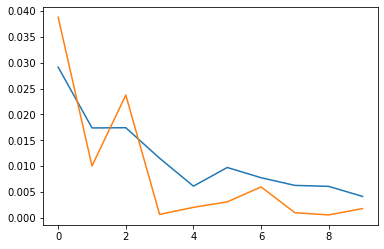

In [218]:
model=lstm(2)
train_loss=[]
val_loss=[]
for ix_epoch in range(10):
    print(f"Epoch {ix_epoch}\n---------")
    a,b=train(df_close, 'Close',model, 'meta',10)
    train_loss.append(a)
    val_loss.append(b.detach().numpy())
plt.plot(train_loss)
plt.plot(val_loss)

scaler = MinMaxScaler(feature_range=(0, 1))
X=df_close[['meta','nasdaq']]
X.columns=['Close','n_Close']
X = pd.DataFrame(scaler.fit_transform(X).copy(),columns=['Close','n_Close'])
X_arr, Y_df = df_conversion(X, 10)
Y_arr = np.array(Y_df['Close'])
model.eval()

res=model(torch.tensor(X_arr[:,:,1:]).float()).detach().numpy()


In [219]:
test=pd.DataFrame(Y_arr)
test['predicted']=res.reshape(-1)
import plotly.express as px
fig = px.line(test)
fig.add_vline(x=197-44, line_width=4, line_dash="dash")
fig.add_annotation(xref="paper", x=0.8, yref="paper", y=0.8, text="Val start", showarrow=False)
fig.show()


In [224]:
test=pd.DataFrame(Y_arr,columns=['actual'])
test['predicted']=res.reshape(-1)
test.columns
import plotly.express as px
fig = px.line(test)
fig.add_vline(x=197-44, line_width=4, line_dash="dash")
fig.add_annotation(xref="paper", x=0.8, yref="paper", y=0.8, text="Val start", showarrow=False)
fig.show()

In [225]:
test=(test-test.shift(periods=1))/test.shift(periods=1)
fig = px.line(test)
fig.add_vline(x=197-44, line_width=4, line_dash="dash")
fig.add_annotation(xref="paper", x=0.8, yref="paper", y=0.8, text="Val start", showarrow=False)
fig.show()

Epoch 0
---------
Train loss: 0.05199955707854208
Val loss: 0.018707315080070012
Epoch 1
---------
Train loss: 0.01835217866498758
Val loss: 0.009901338186213988
Epoch 2
---------
Train loss: 0.01819268471616156
Val loss: 0.009028451925899288
Epoch 3
---------
Train loss: 0.01182430489536594
Val loss: 0.005973056055278431
Epoch 4
---------
Train loss: 0.00845915321534609
Val loss: 0.0046344195589923505
Epoch 5
---------
Train loss: 0.010412520064753206
Val loss: 0.005790550269791596
Epoch 6
---------
Train loss: 0.006966814508332926
Val loss: 0.003570165814677943
Epoch 7
---------
Train loss: 0.009119877687600605
Val loss: 0.0030992271164482902
Epoch 8
---------
Train loss: 0.007850207991021521
Val loss: 0.0036393407019886166
Epoch 9
---------
Train loss: 0.006727384554003091
Val loss: 0.002534345149794756
Epoch 10
---------
Train loss: 0.004449869855307043
Val loss: 0.002083836064173048
Epoch 11
---------
Train loss: 0.007446601781446268
Val loss: 0.009352976705138233
Epoch 0
--------

[0.009352976705138233,
 0.004673177833406916,
 0.004129273120590148,
 0.018026902115893386,
 0.0018106018605630915,
 0.0010107738287581935,
 0.020522509824400043,
 0.02384829743239303,
 0.0029034321223712274,
 0.0029397105108592545]

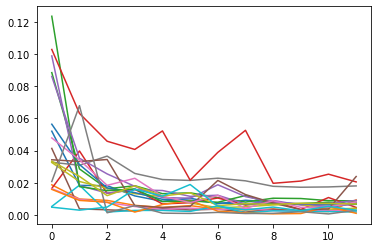

In [186]:
res={}
term_length=10
df_pred=pd.DataFrame(index=df_close.iloc[term_length:-20, :].index)
val_mse=[]
for stock in company_lst:
    model1=lstm(2)
    train_loss=[]
    val_loss=[]
    for ix_epoch in range(12):
        print(f"Epoch {ix_epoch}\n---------")
        a,b=train(df_close, 'Close',model1, stock,term_length)
        train_loss.append(a)
        val_loss.append(b.detach().item())
    plt.plot(train_loss)
    plt.plot(val_loss)
    val_mse.append(b.detach().item())
    scaler = MinMaxScaler(feature_range=(0, 1))
    X=df_close[[stock,'nasdaq']]
    X.columns=['Close','n_Close']
    min_=min(X['Close'])
    max_=max(X['Close'])
    X = pd.DataFrame(scaler.fit_transform(X).copy(),columns=['Close','n_Close'])



    X_s = pd.DataFrame(scaler.fit_transform(X).copy(),columns=['Close','n_Close'])
    X_arr, Y_df = df_conversion(X_s, term_length)
    df_pred[stock]=model1(torch.tensor(X_arr[:-20,:,1:]).float()).detach().numpy()*(max_-min_)+min_
val_mse

In [187]:
print('avergae validation mse:',sum(val_mse)/len(val_mse))

avergae validation mse: 0.00892176553543735


In [188]:
from sklearn.metrics import mean_squared_error as mse
mse(df_close.loc['2022-08-01':'2022-09-30',:'tsla'],df_pred.loc['2022-08-01':,:'tsla'])

57.56597891452312

In [194]:
((df_close.loc['2022-08-01':'2022-09-30',:'tsla']-df_pred.loc['2022-08-01':,:'tsla'])**2).mean()

amd       83.171242
aapl      12.336899
ba        50.055090
biib     168.741977
jpm        7.028585
meta      58.512032
ngg       19.055552
pdd       51.921438
ryaay     13.127050
tsla     111.709925
dtype: float64

In [195]:
df_close.loc['2022-08-01':'2022-09-30',:'tsla'].head(5)

amd        aapl          ba        biib         jpm  \
Date                                                                     
2022-08-01   96.779999  161.285965  169.070007  209.259995  113.197227   
2022-08-02   99.290001  159.788040  163.279999  209.149994  111.433014   
2022-08-03   98.089996  165.899567  166.639999  213.600006  112.602547   
2022-08-04  103.910004  165.580002  166.500000  217.300003  111.363632   
2022-08-05  102.309998  165.350006  165.039993  218.199997  114.733490   

                  meta        ngg        pdd      ryaay        tsla  
Date                                                                 
2022-08-01  159.929993  69.379997  47.689999  74.000000  297.276672  
2022-08-02  160.190002  70.070000  48.980000  71.620003  300.586670  
2022-08-03  168.800003  69.830002  49.650002  73.699997  307.396667  
2022-08-04  170.570007  69.610001  51.259998  74.169998  308.633331  
2022-08-05  167.110001  68.550003  50.250000  74.000000  288.170013

In [196]:
df_pred_r=(df_pred-df_pred.shift(periods=1))/df_pred.shift(periods=1)
df_pred_r

amd      aapl        ba      biib       jpm      meta  \
Date                                                                     
2022-01-18       NaN       NaN       NaN       NaN       NaN       NaN   
2022-01-19 -0.030234 -0.019383 -0.012064 -0.018366 -0.040699 -0.030385   
2022-01-20 -0.015997 -0.012265 -0.026392 -0.009682 -0.017216 -0.005635   
2022-01-21 -0.029049 -0.009658 -0.013521 -0.016359 -0.012414 -0.013775   
2022-01-24 -0.026290 -0.015524 -0.037803 -0.019534 -0.022944 -0.034306   
...              ...       ...       ...       ...       ...       ...   
2022-09-26 -0.024278 -0.013965 -0.046537 -0.008980 -0.016356 -0.015208   
2022-09-27 -0.016933 -0.001621 -0.031510 -0.008294 -0.014956 -0.014732   
2022-09-28  0.002320  0.003972 -0.004853  0.006674 -0.005516 -0.006471   
2022-09-29  0.018526 -0.000879  0.036683  0.305189  0.016535  0.023560   
2022-09-30 -0.035565 -0.034069 -0.040500 -0.036943 -0.014713 -0.021355   

                 ngg       pdd     ryaay      tsla  
Date                                                
2022-01-18       NaN       NaN       NaN       NaN  
2022-01-19 -0.003424  0.006273 -0.026935 -0.026736  
2022-01-20 -0.001245  0.045527 -0.006999 -0.029713  
2022-01-21 -0.002667  0.020000  0.003788 -0.004106  
2022-01-24 -0.005353 -0.057479 -0.010460 -0.051033  
...              ...       ...       ...       ...  
2022-09-26 -0.013200 -0.053154 -0.020912 -0.039580  
2022-09-27 -0.015644  0.019482 -0.021570 -0.000969  
2022-09-28 -0.013968  0.003119 -0.017674  0.021796  
2022-09-29  0.000959  0.029565  0.003651  0.021920  
2022-09-30 -0.010541 -0.039012 -0.015436 -0.058373  

[178 rows x 10 columns]

In [256]:
df_return

amd      aapl        ba      biib       jpm      meta  \
Date                                                                     
2022-01-04 -0.038738 -0.012692  0.027759 -0.009871  0.037910 -0.005937   
2022-01-05 -0.057264 -0.026600 -0.002621 -0.010177 -0.018282 -0.036728   
2022-01-06  0.000588 -0.016693 -0.008119 -0.008233  0.010624  0.025573   
2022-01-07 -0.031050  0.000988  0.019684 -0.019806  0.009908 -0.002015   
2022-01-10  0.000000  0.000116 -0.028724  0.011651  0.000957 -0.011212   
...              ...       ...       ...       ...       ...       ...   
2022-10-24 -0.002040  0.014803  0.005166  0.026156  0.001227 -0.002231   
2022-10-25  0.047189  0.019338  0.032383 -0.003860  0.002615  0.060052   
2022-10-26 -0.028307 -0.019627 -0.087692  0.025113  0.011491 -0.055923   
2022-10-27 -0.018918 -0.030465  0.044622 -0.009129  0.003948 -0.245571   
2022-10-28  0.058191  0.075553  0.029193  0.023104  0.011878  0.012865   

                 ngg       pdd     ryaay      tsla    nasdaq  
Date                                                          
2022-01-04  0.001936 -0.111943  0.024521 -0.041833 -0.013269  
2022-01-05 -0.009662 -0.025893  0.011004 -0.053471 -0.033448  
2022-01-06 -0.010035  0.074181  0.012245 -0.021523 -0.001279  
2022-01-07  0.008166  0.072319  0.039337 -0.035447 -0.009612  
2022-01-10 -0.000978  0.019499 -0.000172  0.030342  0.000464  
...              ...       ...       ...       ...       ...  
2022-10-24  0.021022 -0.246057  0.000315 -0.014876  0.008554  
2022-10-25  0.033288  0.069051  0.028535  0.052876  0.022507  
2022-10-26  0.001676  0.116979  0.031116  0.009981 -0.020370  
2022-10-27  0.008552  0.000377  0.008771  0.002003 -0.016254  
2022-10-28  0.019355 -0.003013  0.000000  0.015238  0.028703  

[207 rows x 11 columns]

In [197]:
### Avg predicted return error of past n days:
def cal_mean_return_error(actual,pred,n):
    a=actual-pred
    tmp=a.copy()
    for i in range(n-1):
        a=a+tmp.shift(periods=i+1)
    return a.shift(1)/10
mean_return_error_10=cal_mean_return_error(df_return.iloc[:,:10],df_pred_r,10)

In [198]:
mean_return_error_10=mean_return_error_10.iloc[20:,:]

In [199]:
mean_return_error_10.loc['2022-09-30',:]

amd     -0.007175
aapl    -0.002538
ba      -0.004623
biib     0.003264
jpm     -0.003900
meta    -0.001686
ngg     -0.006814
pdd     -0.003634
ryaay   -0.006890
tsla    -0.006650
Name: 2022-09-30, dtype: float64

In [200]:
risk_free=0.0404 #for Oct 26 2022
stock_return  = stock_return.iloc[:,:10].copy()
def get_optimal_portfolio(num=10000,date='2022-09-30',method='mv'):
    random_p = np.empty((num, 12))
    ### set a random seed so that optimal potfolio might not change over consecutive date
    np.random.seed(7) 
    for i in range(num):
        random10=np.random.random(10)
        random_weight=random10/np.sum(random10)
        mean_return=stock_return.loc[:date,:].mul(random_weight,axis=1).sum(axis=1).mean()
        annual_return=mean_return * 252
#         annual_return=(1+mean_return)**stock_return.loc[:date,:].shape[0]-1
        cov_mat = stock_return.loc[:date,:].cov()
        cov_mat_annual = cov_mat * 252
        random_volatility=np.sqrt(np.dot(random_weight.T,np.dot(cov_mat_annual,random_weight)))
        pred_return=df_pred_r.loc[date,:].mul(random_weight).sum()
        return_error=mean_return_error_10.loc[date,:].mul(random_weight).sum()
        neg_sharpe_ratio = -(annual_return-risk_free)/random_volatility
    # Minimize var and maximize expected portfolio return and sample period’s abnormal return
        if method == 'mv':
            obj_f=random_volatility-2*pred_return-2*return_error
        elif method == 'sharpe':
            obj_f= neg_sharpe_ratio-2*pred_return-2*return_error
            
        random_p[i][:10]=random_weight
        random_p[i][10]=annual_return
        random_p[i][11]=obj_f
      
    RandomPortfolios=pd.DataFrame(random_p)
    RandomPortfolios.columns=[company +'_weight' for company in company_lst]+['Returns','Obj']

    min_index = RandomPortfolios.Obj.idxmin()

    RandomPortfolios.plot('Obj', 'Returns', kind='scatter', alpha=0.3)
    x = RandomPortfolios.loc[min_index,'Obj']
    y = RandomPortfolios.loc[min_index,'Returns']
    plt.scatter(x, y, color='red')

    plt.text(np.round(x,4),np.round(y,4),(np.round(x,4),np.round(y,4)),ha='left',va='bottom',fontsize=10)
    plt.show()

    numstocks = 10

    GMV_weights = np.array(RandomPortfolios.iloc[min_index, 0:numstocks])

    return GMV_weights

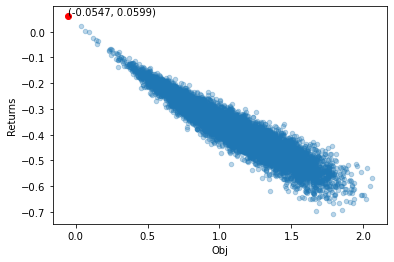

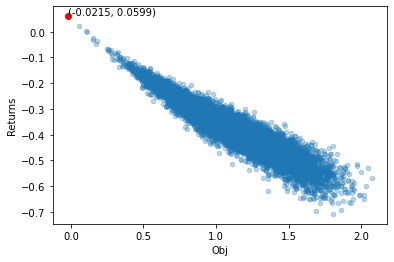

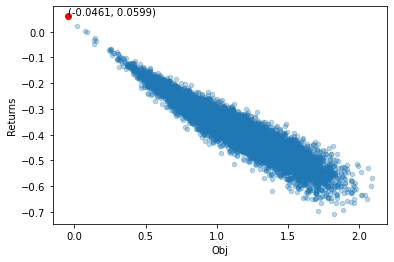

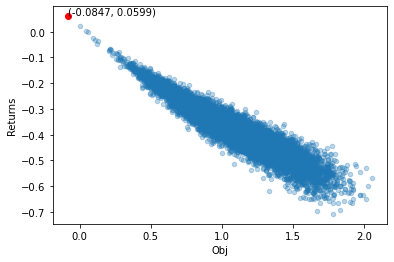

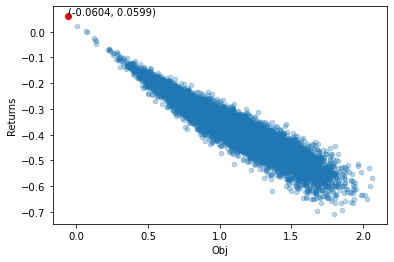

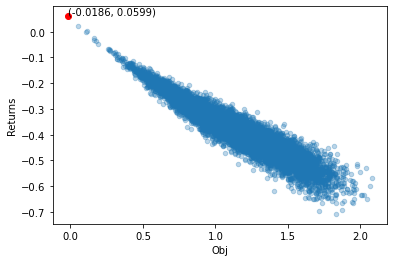

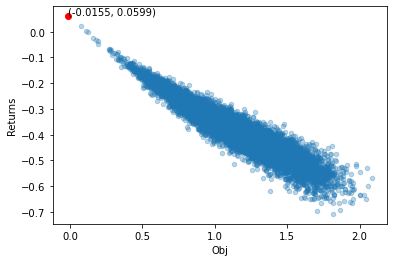

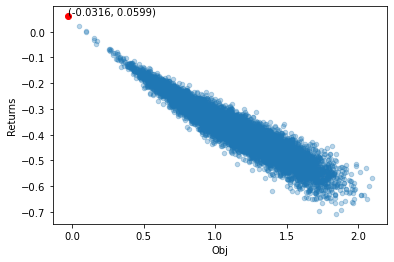

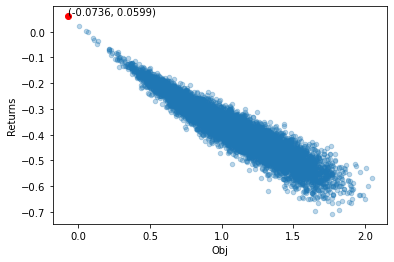

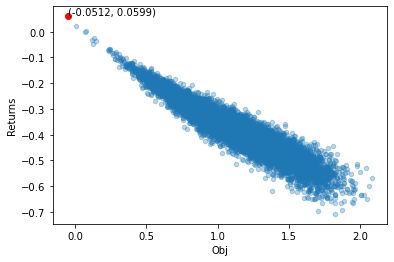

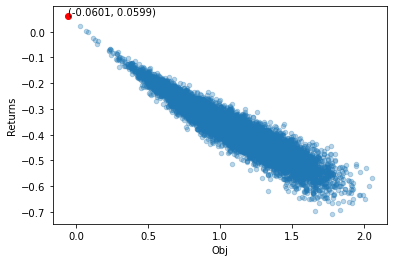

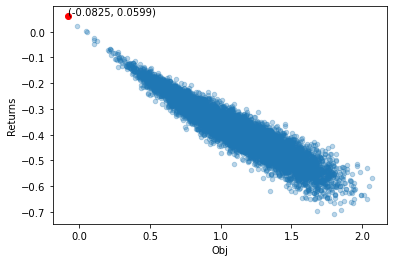

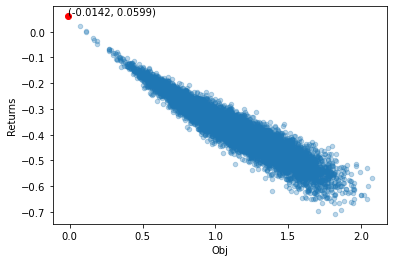

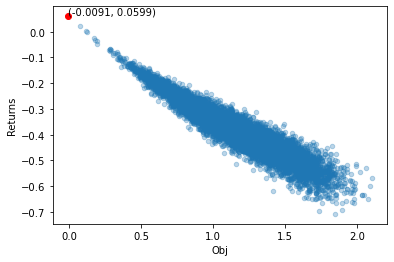

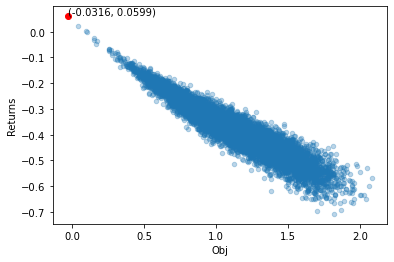

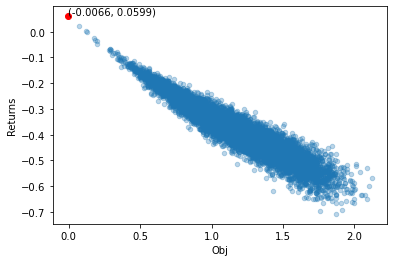

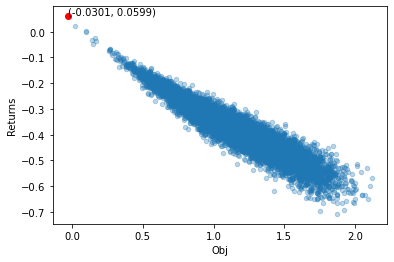

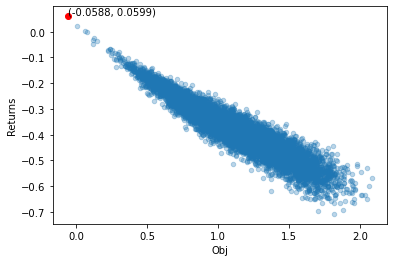

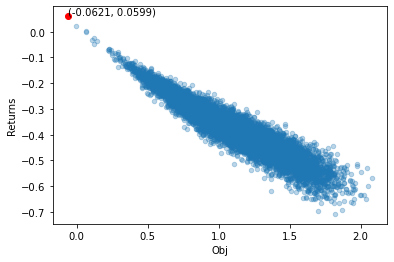

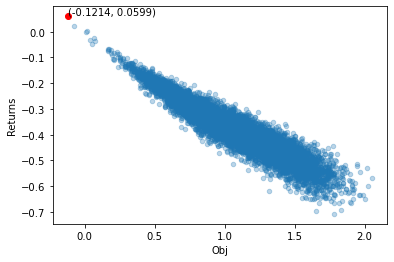

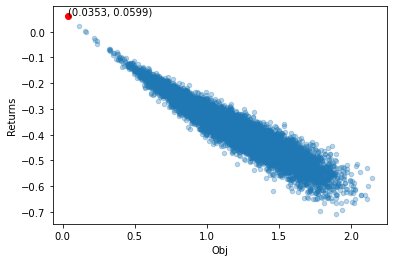

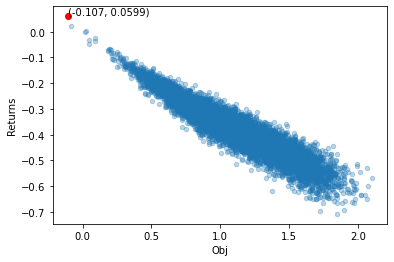

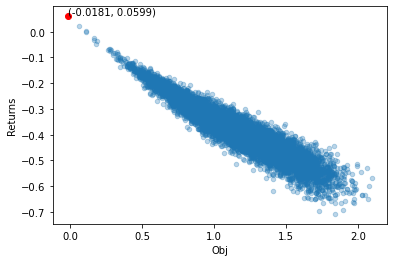

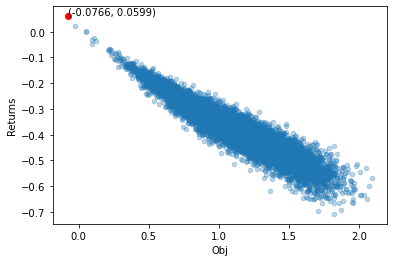

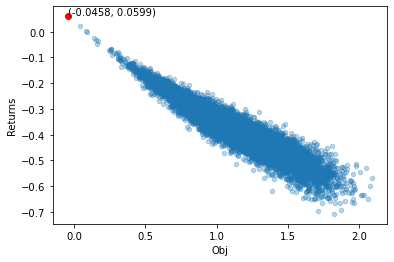

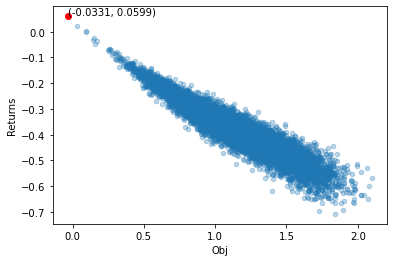

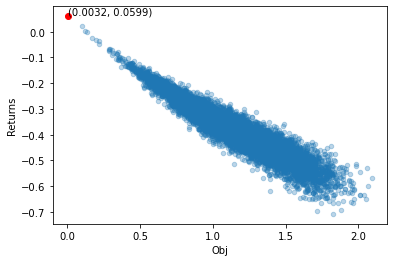

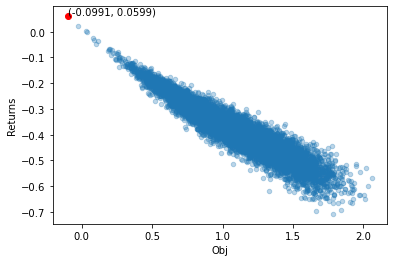

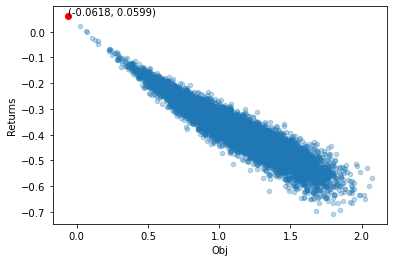

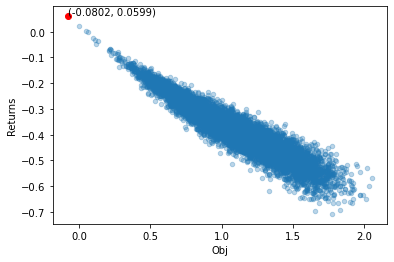

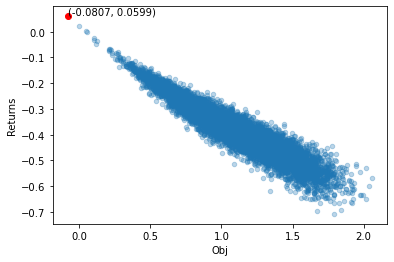

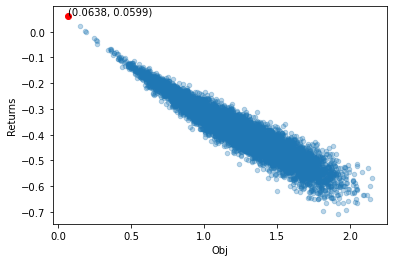

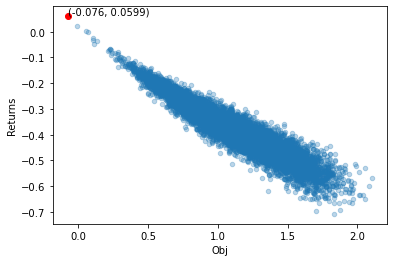

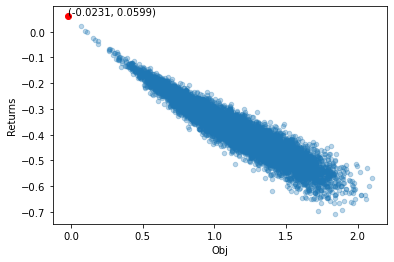

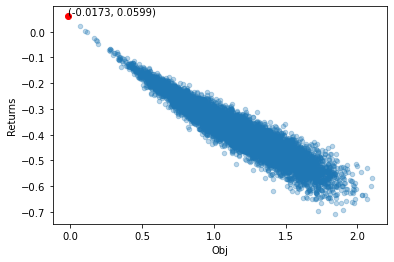

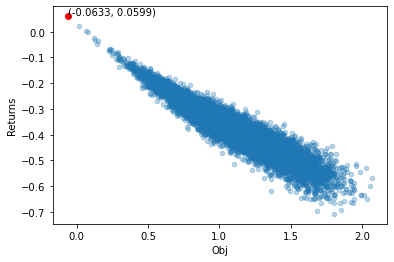

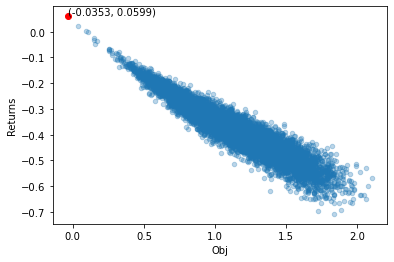

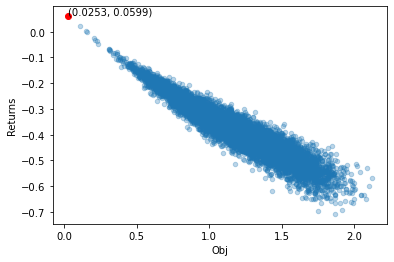

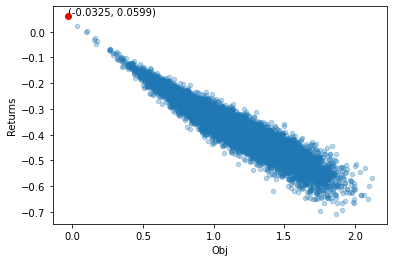

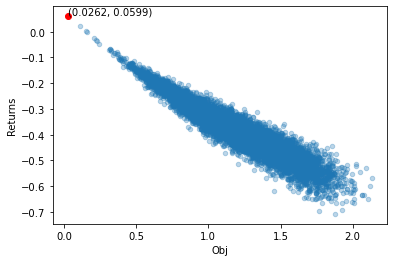

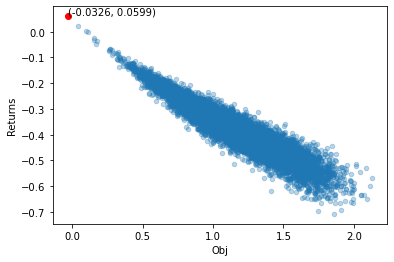

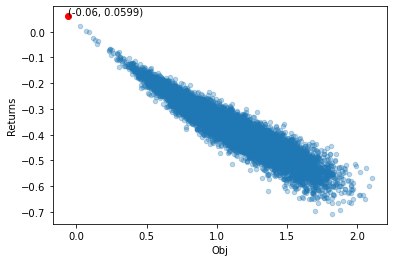

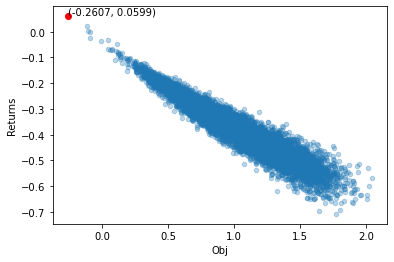

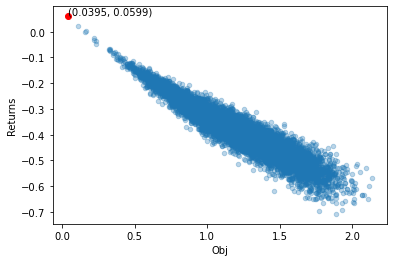

In [201]:
#### get daily optimal weight for Aug and Sep
weight={}
date_list=df_close.iloc[-64:-20, :].index
for date in date_list:
    weight[date]=get_optimal_portfolio(num=10000,date=date,method='sharpe')

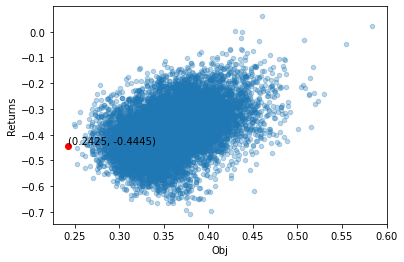

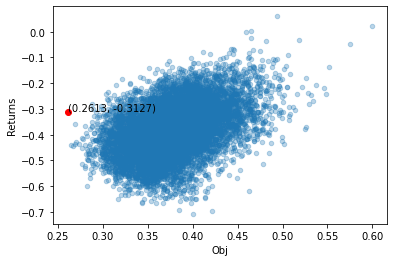

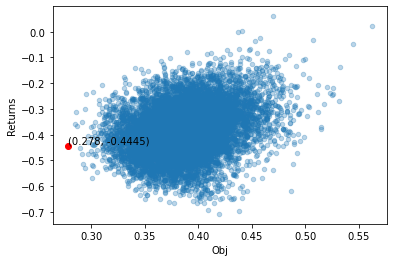

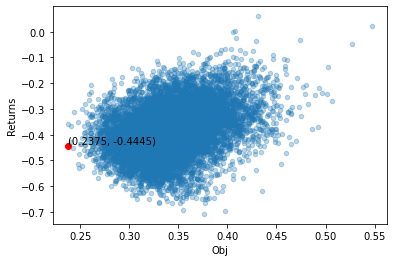

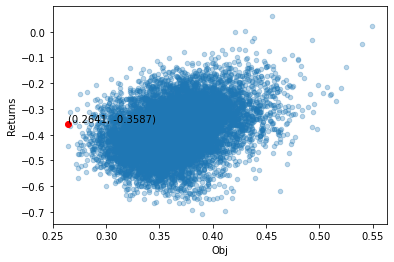

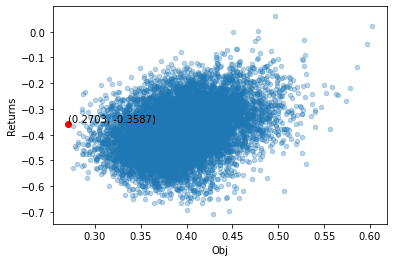

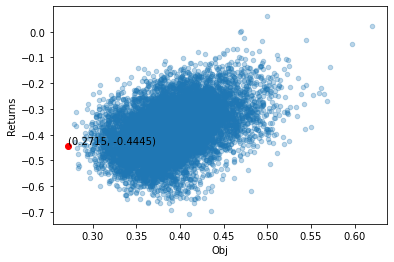

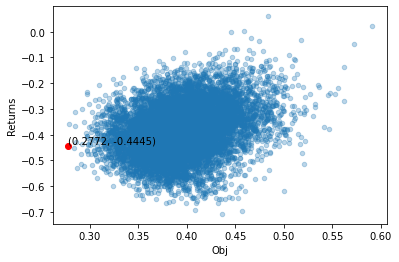

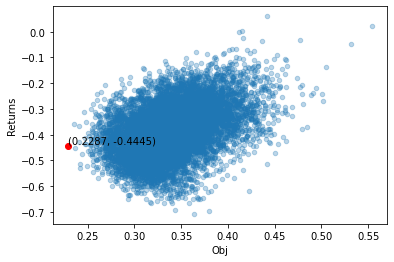

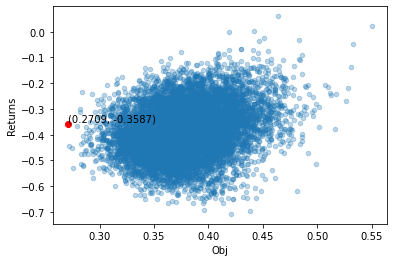

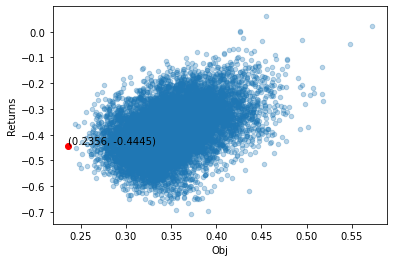

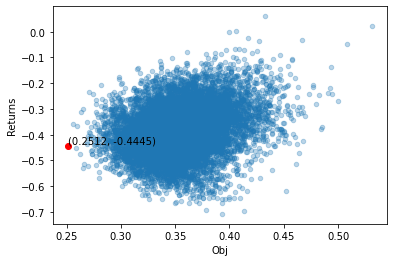

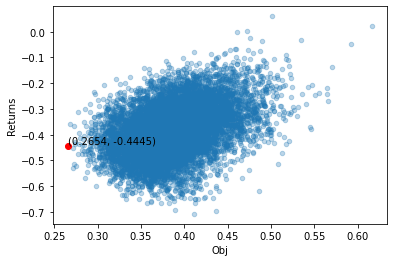

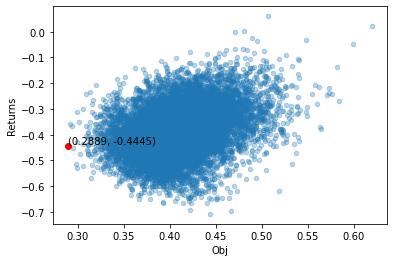

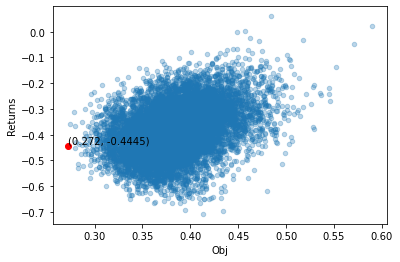

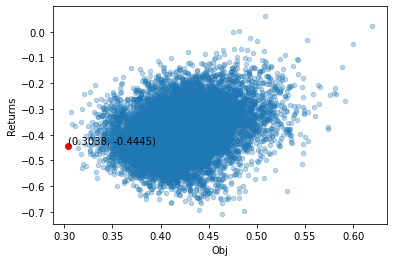

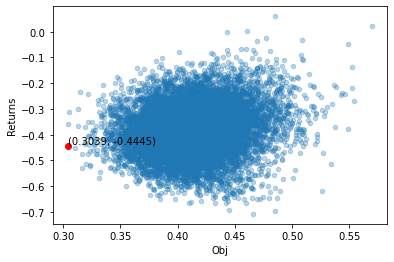

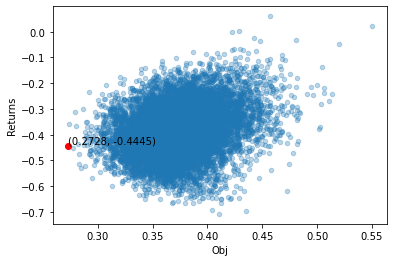

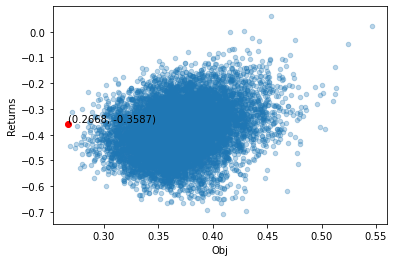

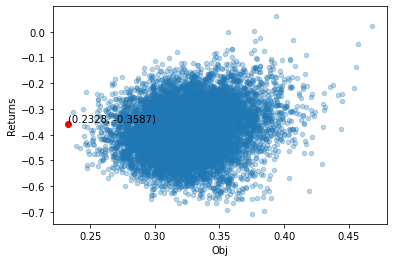

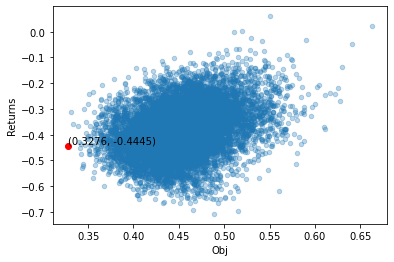

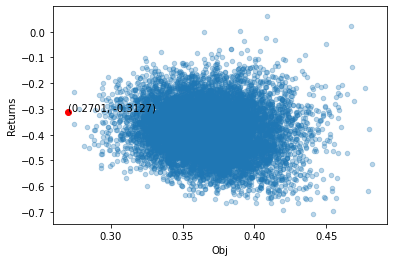

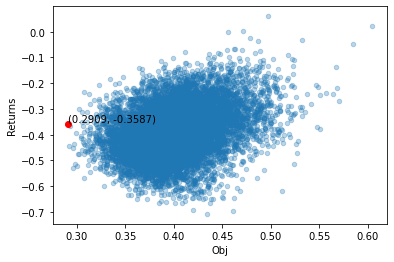

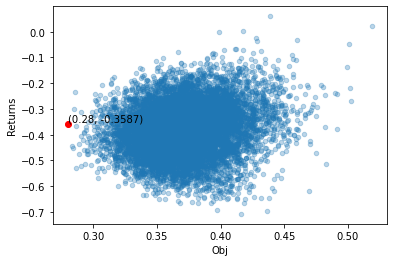

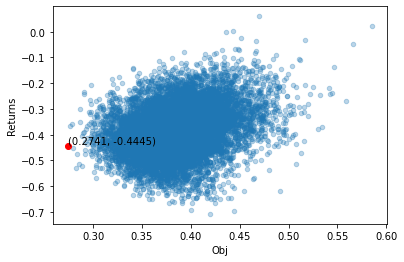

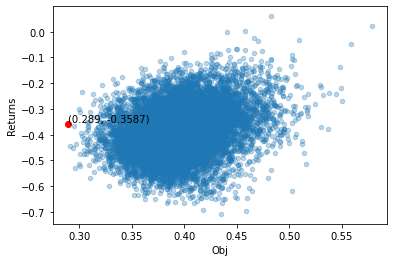

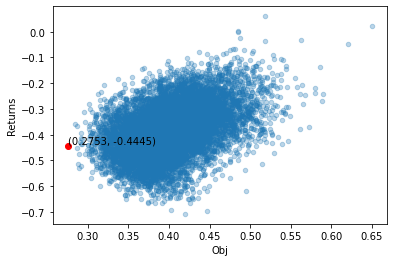

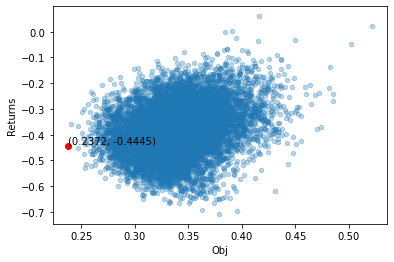

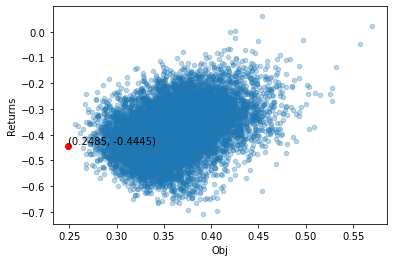

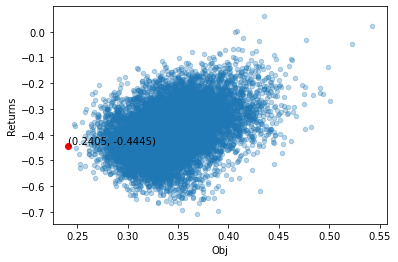

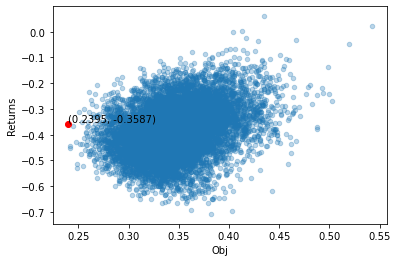

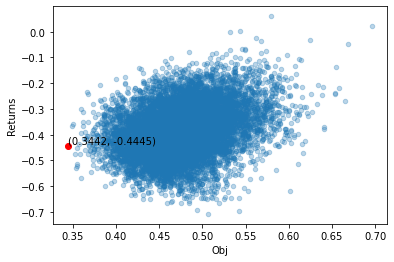

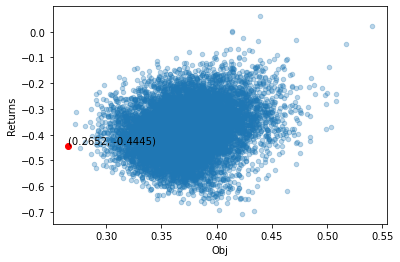

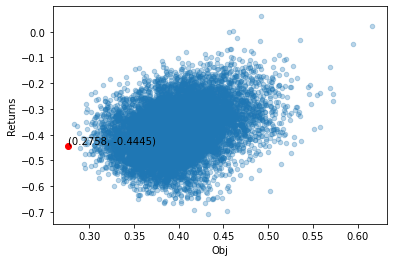

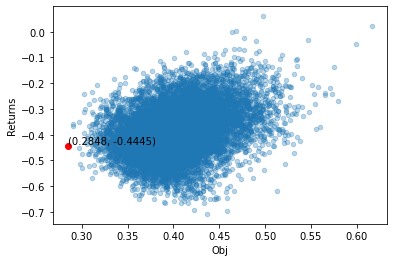

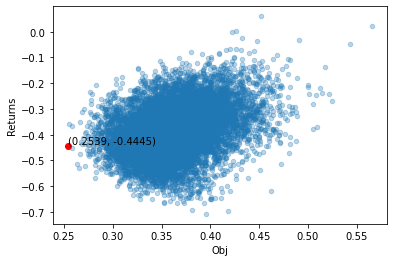

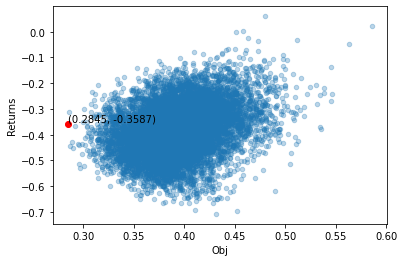

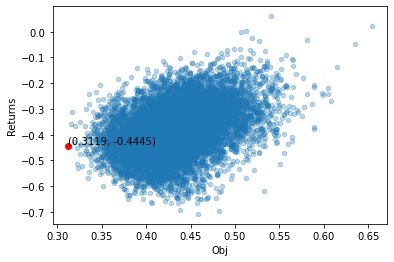

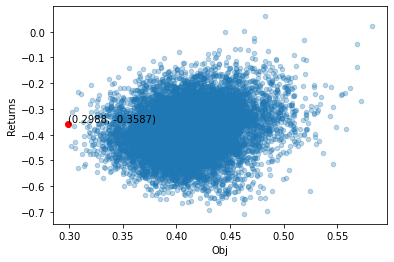

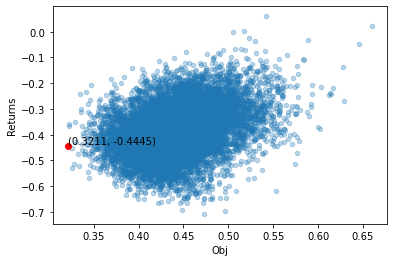

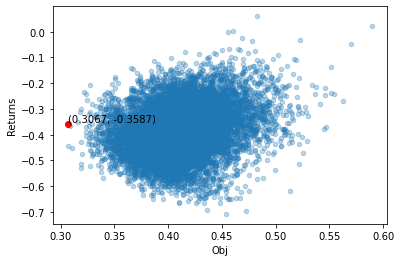

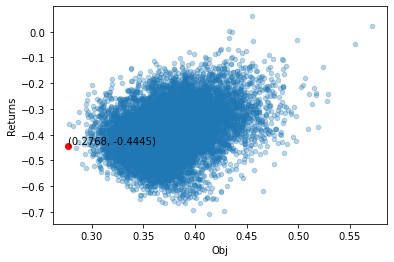

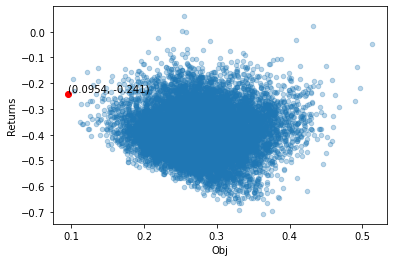

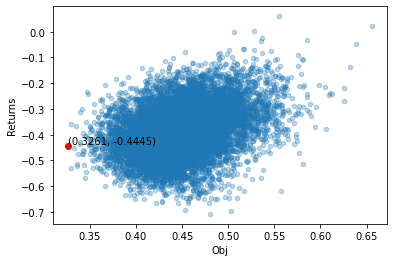

In [202]:
#### get daily optimal weight for Aug and Sep
weight_2={}
date_list=df_close.iloc[-64:-20, :].index
for date in date_list:
    weight_2[date]=get_optimal_portfolio(num=10000,date=date,method='mv')


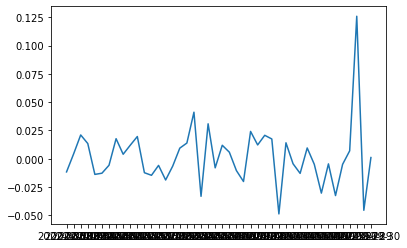

Portfolio validation period return: 6.30%
Portfolio validation period return std: 0.027


In [238]:
### Return for Aug and Sep (Sharpe + Prediction)
WeightedReturns=df_return.loc['2022-08-01':'2022-09-30',:'tsla']*pd.DataFrame.from_dict(weight, orient='index',columns=company_lst)
plt.plot(WeightedReturns.sum(axis=1))
plt.show()
print("Portfolio validation period return: {0:.2f}%".format((np.prod(1+WeightedReturns.sum(axis=1))-1)*100))
print("Portfolio validation period return std: {0:.3f}".format(np.std(WeightedReturns.sum(axis=1))))

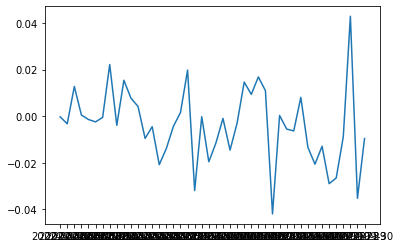

Portfolio validation period return: -16.15%
Portfolio validation period return std: 0.016


In [239]:
### Return for Aug and Sep (MV + Prediction)
WeightedReturns=df_return.loc['2022-08-01':'2022-09-30',:'tsla']*pd.DataFrame.from_dict(weight_2, orient='index',columns=company_lst)
plt.plot(WeightedReturns.sum(axis=1))
plt.show()
print("Portfolio validation period return: {0:.2f}%".format((np.prod(1+WeightedReturns.sum(axis=1))-1)*100))
print("Portfolio validation period return std: {0:.3f}".format(np.std(WeightedReturns.sum(axis=1))))

### Test Result (Oct)

In [206]:
test_df = df_return.loc['2022-10-03':,:'tsla']

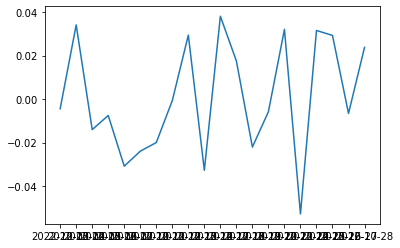

Portfolio test period return: 0.70%


In [207]:
### Return based on (Sharpe + Prediction) last date weight
WeightedReturns=test_df.mul(weight['2022-09-30'], axis=1)
plt.plot(WeightedReturns.sum(axis=1))
plt.show()
print("Portfolio test period return: {0:.2f}%".format((np.prod(1+WeightedReturns.sum(axis=1))-1)*100))

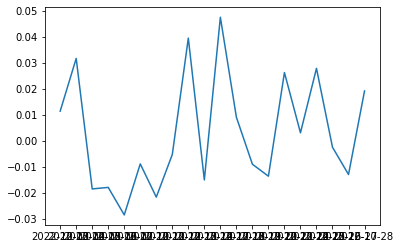

Portfolio test period return: 6.00%


In [208]:
### Return based on (Sharpe + Prediction) last date weight
WeightedReturns=test_df.mul(weight_2['2022-09-30'], axis=1)
plt.plot(WeightedReturns.sum(axis=1))
plt.show()
print("Portfolio test period return: {0:.2f}%".format((np.prod(1+WeightedReturns.sum(axis=1))-1)*100))

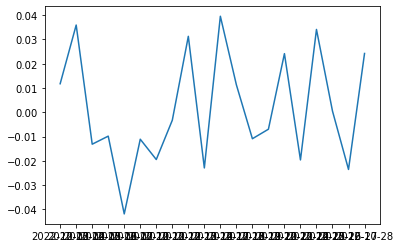

Portfolio test period return: 2.51%


In [209]:
portfolio_weights = np.array([0.1]*10)
WeightedReturns=test_df.mul(portfolio_weights, axis=1)
plt.plot(WeightedReturns.sum(axis=1))
plt.show()
print("Portfolio test period return: {0:.2f}%".format((np.prod(1+WeightedReturns.sum(axis=1))-1)*100))